In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import pandas as pd
import os

# Correct directory with nested activity folders
DATA_DIR = r"C:\Users\JOEL ABHISHEK BEERA\Downloads\MotionSense Dataset\A_DeviceMotion_data\A_DeviceMotion_data"

# Recursively get all CSV file paths
all_csv_paths = []
for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        if file.endswith('.csv'):
            full_path = os.path.join(root, file)
            all_csv_paths.append(full_path)

print("Total CSV files found:", len(all_csv_paths))

# Load and concatenate all CSVs
data_list = []

for path in all_csv_paths:
    df = pd.read_csv(path)
    df['trial'] = os.path.basename(path)  # name of the file
    df['activity'] = os.path.basename(os.path.dirname(path))  # name of folder (e.g., jog_1)
    data_list.append(df)

data = pd.concat(data_list, ignore_index=True)
print("Shape:", data.shape)
data.head()


Total CSV files found: 360
Shape: (1412865, 15)


,Unnamed: 0,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,trial,activity
0,0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,sub_1.csv,dws_1
1,1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,sub_1.csv,dws_1
2,2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,sub_1.csv,dws_1
3,3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,sub_1.csv,dws_1
4,4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,sub_1.csv,dws_1


In [4]:
from sklearn.preprocessing import StandardScaler

# Select only sensor features
features = [
    'attitude.roll', 'attitude.pitch', 'attitude.yaw',
    'gravity.x', 'gravity.y', 'gravity.z',
    'rotationRate.x', 'rotationRate.y', 'rotationRate.z',
    'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z'
]

In [5]:
from sklearn.preprocessing import StandardScaler

# Drop any rows with missing values in the selected features
data_clean = data.dropna(subset=features)

# Extract features into a matrix X
X = data_clean[features].values

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optional: attach to dataframe for inspection
data_clean[features] = X_scaled

# Kmeans

In [6]:
from sklearn.cluster import KMeans

# Choose number of clusters (we'll try 6 for the 6 known activities)
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels back to the DataFrame
data_clean['cluster'] = clusters

In [7]:
data_clean['cluster'].value_counts().sort_index()

cluster
0    110073
1    256960
2    202889
3    411249
4    258465
5    173229
Name: count, dtype: int64

In [8]:
# Extract only activity label (e.g., 'jog' from 'jog_2')
data_clean['activity_clean'] = data_clean['activity'].str.extract(r'([a-z]+)')

# Now compare cluster vs actual activity
pd.crosstab(data_clean['cluster'], data_clean['activity_clean'])


activity_clean,dws,jog,sit,std,ups,wlk
cluster,,,,,,
0,3857,1289,99680,335,3416,1496
1,22249,17491,88,134072,25427,57633
2,30586,31901,263,47418,28488,64233
3,49476,42115,12269,121691,66286,119412
4,2636,5818,226455,2874,7245,13437
5,23052,35617,23,37,26423,88077


## cluster 2 and 5 are able to distinguish sitting 
## cluster 3 for standing
## cluster 4 is a mix

# PCA and Tsne


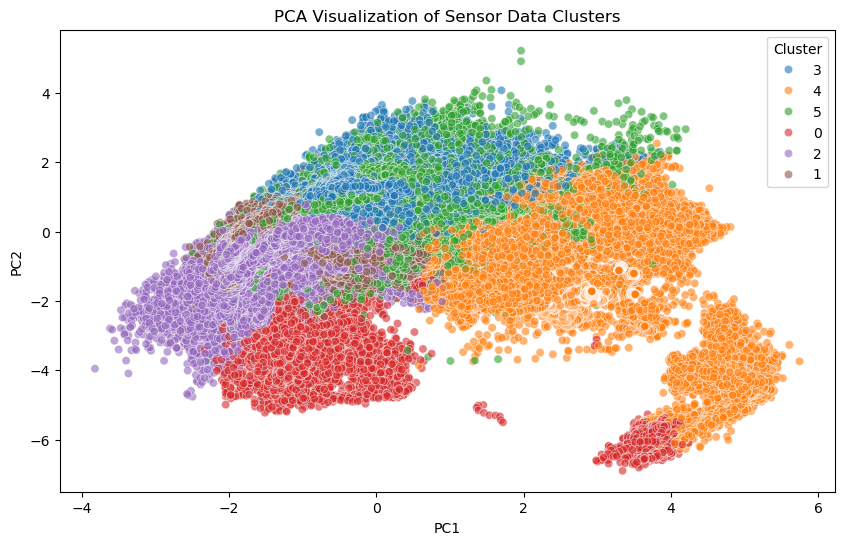

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create DataFrame for plotting
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': data_clean['cluster'].astype(str),  # as string for color
    'Activity': data_clean['activity_clean']
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10', alpha=0.6)
plt.title('PCA Visualization of Sensor Data Clusters')
plt.legend(title='Cluster')
plt.show()


## PCA Colored by True Activity

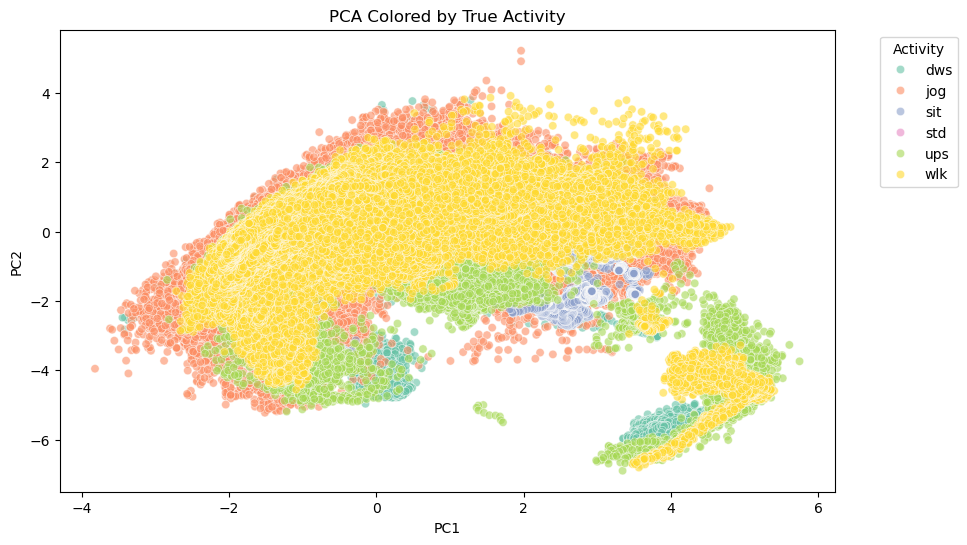

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Activity', palette='Set2', alpha=0.6)
plt.title('PCA Colored by True Activity')
plt.legend(title='Activity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Tsne was interrupted as it was taking a lot of time. tried using x_pca to move things quickly but still not optimal.
# UMAP is recommended over TNSE

In [ ]:
from sklearn.manifold import TSNE

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# Create DataFrame for plotting
tsne_df = pd.DataFrame({
    'Dim1': X_tsne[:, 0],
    'Dim2': X_tsne[:, 1],
    'Cluster': data_clean['cluster'].astype(str),
    'Activity': data_clean['activity_clean']
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', hue='Cluster', palette='tab10', alpha=0.6)
plt.title('t-SNE Visualization of Clusters')
plt.legend(title='Cluster')
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', hue='Activity', palette='Set2', alpha=0.6)
plt.title('t-SNE Colored by True Activity')
plt.legend(title='Activity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Evaluating

## ARI - 0.21 -> not ideal as clusters werent aligned. different clustering algorithems like dbscan and feature engineering are the next steps from here

In [12]:
from sklearn.metrics import adjusted_rand_score

# Compare cluster assignments to actual activity labels
ari = adjusted_rand_score(data_clean['activity_clean'], data_clean['cluster'])
print(f"Adjusted Rand Index (ARI): {ari:.4f}")


Adjusted Rand Index (ARI): 0.2143


In [ ]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(X_scaled, data_clean['cluster'])
print(f"Silhouette Score: {sil_score:.4f}")


In [14]:
import numpy as np
from sklearn.metrics import silhouette_score

# Sample 10,000 (or fewer if dataset is small)
sample_size = 10000
if len(X_scaled) > sample_size:
    sample_indices = np.random.choice(len(X_scaled), size=sample_size, replace=False)
    sil_score = silhouette_score(X_scaled[sample_indices], data_clean['cluster'].values[sample_indices])
else:
    sil_score = silhouette_score(X_scaled, data_clean['cluster'])

print(f"Silhouette Score (sampled): {sil_score:.4f}")

Silhouette Score (sampled): 0.2148


# silhouette score says there is overlap which is clearly visible in the scatterplots